In [2]:
from collections import namedtuple

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features

* Conference paper presented at International Conference on Computer Vision.

## Abstract

* "Regional dropout strategies" like CutOut and RandomErasing and so on help to allow model to focus on less discriminative parts of objects.
  * Model generalises better and has better object localisation: eg training might focus on leg instead of obvious things like a head.

* The paper claims that removing information pixels leads to "information loss" and "inefficiency"
  * In other words, the model is not seeing anything useful when you randomly erase parts of the image.
 
* Therefore, CutMix: cut and paste patches from images in a batch and mix ground truth labels proportionally to the image.

* Claims to outperform state-of-the-art on CIFAR and ImageNet.
  * When using pretrained weights with CutMix training on ImageNet, results in performacne gains for Pascal detection and MS-COCO image captioning benchmarks.

## 1. Introduction

## 2. Related Works

* Regional Dropout:
  * Removing random regions:
      * [[3] CutOut: removing random regions in images](https://arxiv.org/pdf/1708.04552.pdf)
        * Set random patches to 0.
      * [[51] Random Erasing Data Augmentation](https://arxiv.org/pdf/1708.04896.pdf)
        * Set random patches to random values.
  * Intelligently removing regions:
    * [[2] Attention-based dropout
layer for weakly supervised object localization](https://arxiv.org/abs/1908.10028)
  * Removing regions from the feature space.
    * [[8] DropBlock](https://arxiv.org/abs/1810.12890)
      * Apply Dropout to convolution layers not effective because spatially adjacent pixels are strongly correlated. So if you drop out some convolution nodes, another will be availabel with similar information.
      * Structured dropout where units in a contiguous region of a feature map are dropped together.
      
* Synthesizing training data:
  * Stylizing ImageNet:
    * [[7] ImageNet-trained CNNs are biased towards texture; increasing shape bias improves accuracy and robustness](https://arxiv.org/abs/1811.12231)
      * found that models tend to prefer to learn texture than shape. Which is at odds with how humans learn.
      * by creating a "stylised imagenet", basically, changing textures of images in ImageNet, they were able to get the model to focus on shape, which provided a performance boost in a lot of comp vision tasks.
      
* MixUp
  * [[48] mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)
    * Interpolation of two images in a batch.
    * Makes the model more robust to adversarial examples but comes at a cost of object localisation ability.
  * [[41] Between-class learning for image classification](https://arxiv.org/pdf/1711.10284.pdf)
    * Basically, identical to MixUp.
    * Includes some ideas about how to works: "we argue that CNNs have an aspect of treating the input data as waveforms. In that case, a mixture of two images is a mixture of two waveforms. This make sense for machines, although it does not visually make sense for humans."
  * [[42] Manifold mixup: Better representations by interpolating hidden states](https://arxiv.org/abs/1806.05236)
    * Interpolations of hidden representations.
  * [[40] Ricap: Random image cropping and patching data augmentation for deep cnns](https://arxiv.org/pdf/1811.09030.pdf)
    * Very similar to CutMix. Really, the same thing.
  * [[35] Improved Mixed-Example Data Augmentation](https://arxiv.org/pdf/1805.11272.pdf)
    * Also, very similar to CutMix paper. Tests a couple of alternative image combinating techniques.
  * [[10] MixUp as Locally Linear Out-Of-Manifold Regularization (AdaMixup)](https://arxiv.org/abs/1809.02499)
    * AdaMixUp regulariser:
        * Mixing policies are learned from the data using another network.
          * Objective function designed to avoid "manifold intrusion".
* Tricks for training deep networks:
  * [[34] Dropout](http://jmlr.org/papers/v15/srivastava14a.html)
    * Discards info by randomly zeroing activations of neural network during training phase.
  * [[18] Batch normalization:
Accelerating deep network training by reducing internal covariate shift]
    * Normalise layers throughout network.
  * [[17] Deep networks with stochastic depth](https://arxiv.org/abs/1603.09382)
  * [[46] Shakedrop regularization for deep residual
learning](https://arxiv.org/abs/1802.02375)
    * Li 

## 3. CutMix

### 3.1. Algorithm

Let $x ∈ RW×H×C$ and $y$ denote a training image and its label, respectively.

In [19]:
label = namedtuple('Label', ['dog', 'cat'])

x = np.array(Image.open('images/dog.jpg').resize((224, 224), resample=Image.BOX)) / 255.
y = np.array(label(dog=1, cat=0))

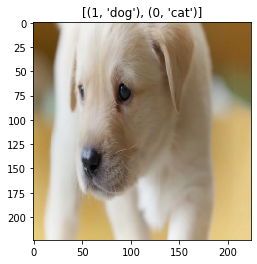

In [20]:
plt.imshow(x)
plt.title(list(zip(y, label._fields)))
plt.show()

We'll also create another training image and a label $xB$ and $yB$

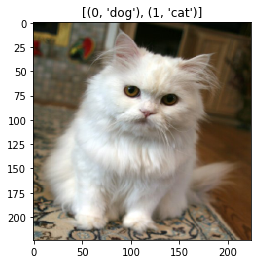

In [21]:
xB = np.array(Image.open('images/cat.jpg').resize((224, 224), resample=Image.BOX)) / 255.
yB = np.array(label(dog=0, cat=1))

plt.imshow(xB)
plt.title(list(zip(yB, label._fields)))
plt.show()

The goal of CutMix is to generate a new training sample $(\hat{x}, \hat{y})$ by combining two training samples ($xA$, $yA$) and ($xB$, $yB$)

### MixUp

Sidenote: How does MixUp do it? With a linear interpolation:

In [22]:
alpha = 0.6

x_hat = ((alpha * x) + ((1 - alpha) * xB))
y_hat = ((alpha * y) + ((1 - alpha) * yB))

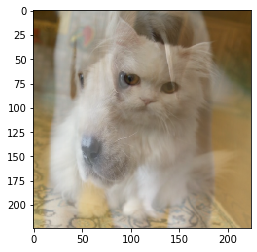

In [23]:
plt.imshow(x_hat)

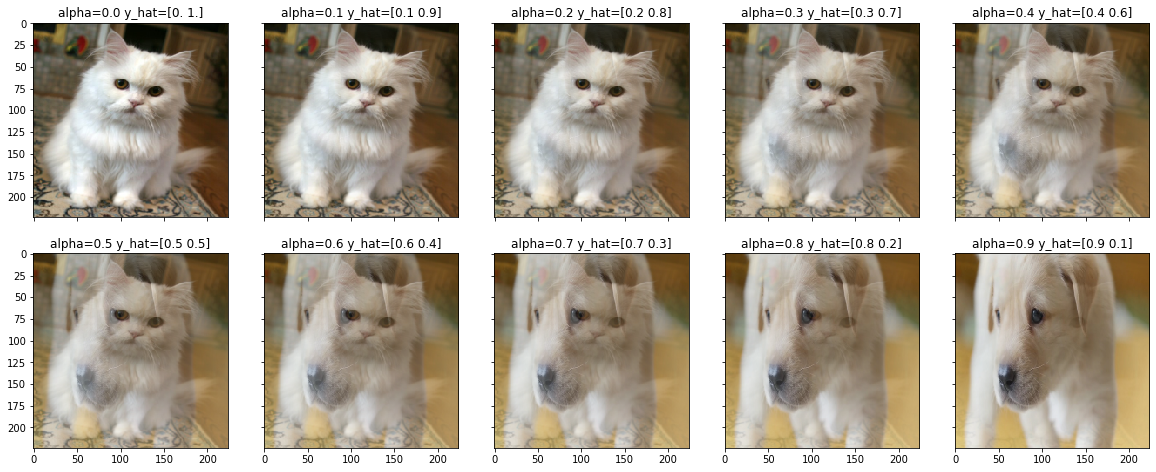

In [24]:
fig = plt.figure(figsize=(20., 16.))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(2, 5),  # creates 2x2 grid of axes
    axes_pad=0.5,  # pad between axes in inch.
)

for ax, i in zip(grid, range(0, 10)):
    alpha = 1e-1 * i
    
    x_hat = ((alpha * x) + ((1 - alpha) * xB))
    y_hat = ((alpha * y) + ((1 - alpha) * yB))
    
    # Iterating over the grid returns the Axes.
    ax.imshow(x_hat)
    ax.set_title(f'alpha={round(alpha, 2)} y_hat={y_hat}')

plt.show()

Back to CutMix, we define the combining operation as:

$\hat{x} = M \odot x + (1 − M) \odot xB$

$\hat{y} = \lambda y + (1 − \lambda) yB$

where $M \in {0, 1}$ denotes a binary mask where to drop out and fill in from two images. 1 is a binary mask filled with ones and $\odot$ is element-wise multiplication.

The combination ratio $\lambda$ between two data points is sampled from the beta distribution $Beta(α, α)$, in all the experiments, they set $\alpha$ to 1. So $\lambda$ is sampled from the uniform distribution (0, 1).

To sample the binary mask, they first sample a point somewhere in the image:

In [25]:
width, height = xB.shape[:2]

In [27]:
cut_x = np.random.randint(width)
cut_y = np.random.randint(height)

cut_x, cut_y

(117, 34)

Then figure out the size of the bounding box using the ratio lambda.

In [28]:
cut_width = int(round(width * np.sqrt(1 - 0.6)))
cut_height = int(round(height * np.sqrt(1 - 0.6)))

In [29]:
cut_width, cut_height

(142, 142)

The cropped area ratio should be 0.4:

In [30]:
(cut_width * cut_width) / (width * height)

0.4018654336734694

In a function:

In [34]:
def get_mask(alpha=1.):
    mask = np.ones((224, 224, 3))
    
    ratio = np.random.beta(alpha, alpha)

    width = mask.shape[0]
    height = mask.shape[1]
    
    cut_width = int(round(width * np.sqrt(1 - ratio)))
    cut_height = int(round(height * np.sqrt(1 - ratio)))
    
    cut_x = np.random.randint(width)
    cut_y = np.random.randint(height)
    
    box_x1 = np.clip(cut_x - cut_width // 2, 0, width)
    box_x2 = np.clip(cut_x + cut_width // 2, 0, width)

    box_y1 = np.clip(cut_y - cut_height // 2, 0, height)
    box_y2 = np.clip(cut_y + cut_height // 2, 0, height)

    mask[box_x1:box_x2, box_y1:box_y2] = 0
    
    actual_ratio = 1 - ((box_x2 - box_x1) * (box_y2 - box_y1) / (height * width))
    
    return mask, actual_ratio

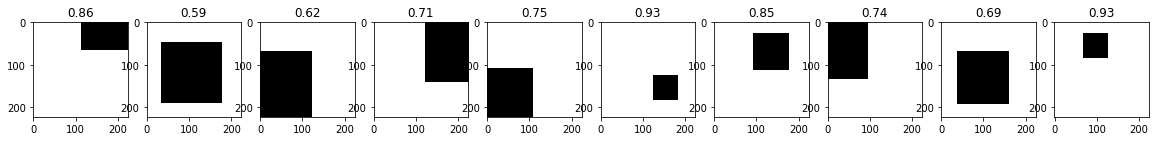

In [35]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    mask, ratio = get_mask()
    plt.imshow(mask)
    plt.title(round(ratio, 2))

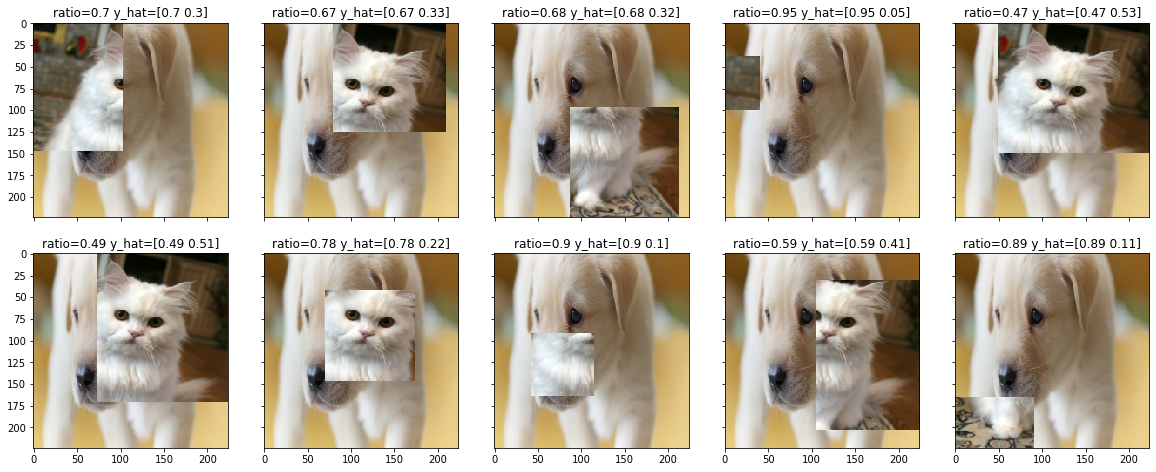

In [37]:
fig = plt.figure(figsize=(20., 16.))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(2, 5),  # creates 2x2 grid of axes
    axes_pad=0.5,  # pad between axes in inch.
)

for ax, i in zip(grid, range(0, 10)):
    mask, ratio = get_mask()
    x_hat = (mask * x) + (1 - mask) * xB
    ax.imshow(x_hat)
    y_hat = ((ratio * y) + ((1 - ratio) * yB))
    ax.set_title(f'ratio={round(ratio, 2)} y_hat={np.round(y_hat, 2)}')

plt.show()

Then, for each mini-batch, you construct each sample by randomly cutting and pasting from another sample in the batch.

In PyTorch, it'd look something like this:

```
for i, (input, target) in enumerate(train_dl):
    input = input.cuda()
    target = target.cuda()
   
    lam = np.random.beta(args.beta, args.beta)
    rand_index = torch.randperm(input.size()[0]).cuda()
    target_a = target
    target_b = target[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
    input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))
    # compute output
    output = model(input)
    loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)
```

### 3.2. Discussion

* Visually compare activation maps for CutMix against Cutout and Mixup.
* Find that CutOut lets model focus on less discriminative parts of object, like belly of St Bernard.
* CutMix improves upnon that by localizing the 2 object classes accuractely.
* Allows model to train for longer and achieves better validation performance.